Code from [scale embedding-decoder](https://git.scc.kit.edu/scale/research/embedding-decoder) with slight changes

In [ ]:
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from util.map import Map
from util.generate_points import list_to_dict, gen_square, gen_disc

wandb.login()

In [ ]:
wandb.init(project="embedding-eval-framework", entity="hydrofin")
wandb.run

In [3]:
args = Map(
    batch_size = 64,
    epochs = 50,
    random_seed = None,
    graph_size = 1000,
    graph_average_degree = 10,
    rg_radius = 0.05,
    layers = 10,
    layer_size = 16,
    train_size = 0.7
)

Nodes: 1000
Edges: 4837
Average Degree: 9.674
Largest Component Size: 1000


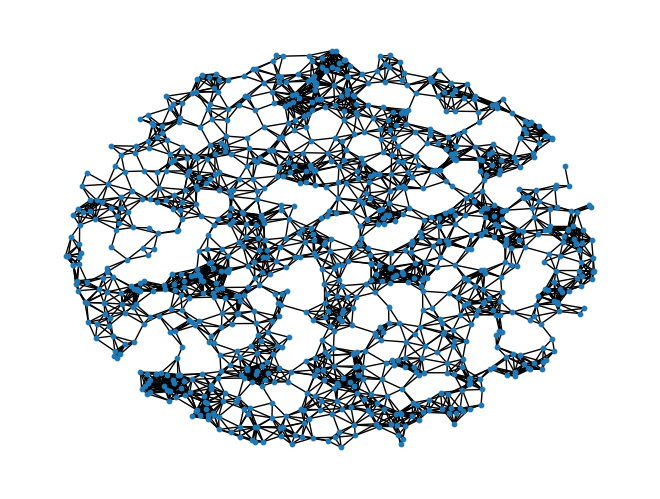

In [4]:
rg_radius = args.rg_radius if args.rg_radius > 0 else math.sqrt(args.graph_average_degree / (args.graph_size * math.pi))

pos = list_to_dict(gen_disc(args.graph_size))
nx_graph = nx.random_geometric_graph(args.graph_size, rg_radius, pos=pos)  # not based on rng seed yet!
largest_component = max(nx.connected_components(nx_graph), key=len)

print(f'Nodes: {nx_graph.number_of_nodes()}')
print(f'Edges: {nx_graph.number_of_edges()}')
print(f'Average Degree: {2.0 * nx_graph.number_of_edges() / nx_graph.number_of_nodes()}')
print(f'Largest Component Size: {len(largest_component)}')
#pos = nx.circular_layout(nx_graph)
nx.draw(nx_graph, pos, node_size=10)

wandb.log({
    "generated_graph": wandb.Image(plt)
})

In [5]:
#graph_nodes_pos = [ node['pos'] for node in  ]

graph_nodes = nx.nodes(nx_graph)

# all combinations of x and y (with x > y)
print("generating edge pairs...", end='')
ds_edge_pairs = [ [ei0, ei1] for ei0 in range(nx_graph.number_of_nodes()) for ei1 in range(ei0 + 1, nx_graph.number_of_nodes()) ]
print(f"DONE generated {len(ds_edge_pairs)} pairs")
ds_edges_pos = [ [graph_nodes[ei0]['pos'][0], graph_nodes[ei0]['pos'][1], graph_nodes[ei1]['pos'][0], graph_nodes[ei1]['pos'][1]] for [ei0, ei1] in tqdm(ds_edge_pairs, desc="mapping edge positions") ]
ds_edges_label = [ 1 if nx_graph.has_edge(ei0, ei1) else 0 for [ei0, ei1] in tqdm(ds_edge_pairs, desc="creating labels for edges") ]

def z2polar(z: (float, float)) -> [float, float]:
    rho = np.sqrt(z[0]**2 + z[1]**2)
    phi = np.arctan2(z[1], z[0])
    return [rho, phi]

def zs2polars(zs: [(float, float)]) -> [float, float]:
    return np.array([ z2polar(z) for z in zs ]).flatten()

generating edge pairs...DONE generated 499500 pairs


creating labels for edges: 100%|██████████| 499500/499500 [00:00<00:00, 2714715.90it/s]


In [6]:
# tensorflow

# generate dataset from graph from previous
full_dataset = tf.data.Dataset.from_tensor_slices((ds_edges_pos, ds_edges_label)).batch(args.batch_size)

# split dataset
full_dataset = full_dataset.shuffle(nx_graph.number_of_nodes())
train_dataset = full_dataset.take(int(args.train_size * nx_graph.number_of_nodes()))
test_dataset = full_dataset.take(int((1 - args.train_size) * nx_graph.number_of_nodes()))

# build model(s)
model_array = [
    tf.keras.layers.InputLayer(input_shape=(4))] #possible TODO get inputshape dynamically

for i in range(args.layers):
    model_array.append(tf.keras.layers.Dense(args.layer_size, activation='relu')) #make size depending of graph dimensionality? Or would that against the idea?

model_array.append(tf.keras.layers.Flatten())
model_array.append(tf.keras.layers.Dense(1, activation='sigmoid'))

dense_model = tf.keras.Sequential(model_array)

dense_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(), # TODO try other loss function
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(thresholds=0),
        tf.keras.metrics.AUC(
            curve="PR"
        ),
        #tfma.metrics.AUCPrecisionRecall()
    ]
)

# train
train_history = dense_model.fit(train_dataset, epochs=args.epochs, callbacks=[WandbCallback()])

# evaluate
test_loss, test_acc, e1, e2 = dense_model.evaluate(test_dataset, verbose=0)
dense_model.summary()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
700/700 [==============================] - 3s 1ms/step - loss: 0.0801 - accuracy: 0.9907 - recall: 1.0000 - auc: 0.0197
Epoch 2/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0209 - accuracy: 0.9912 - recall: 1.0000 - auc: 0.4859
Epoch 3/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0165 - accuracy: 0.9928 - recall: 1.0000 - auc: 0.5494
Epoch 4/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0145 - accuracy: 0.9938 - recall: 1.0000 - auc: 0.6446
Epoch 5/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0137 - accuracy: 0.9938 - recall: 1.0000 - auc: 0.6439
Epoch 6/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0119 - accuracy: 0.9946 - recall: 1.0000 - auc: 0.7105
Epoch 7/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0118 - accuracy: 0.9949 - recall: 1.0000 - auc: 0.7631
Epoch 8/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0114 - 

In [7]:
predictions = dense_model.predict(ds_edges_pos) # cartesian

15610/15610 [==============================] - 10s 632us/step


In [8]:
predictions

array([[3.2620175e-31],
       [1.4646701e-11],
       [0.0000000e+00],
       ...,
       [1.5976013e-20],
       [1.1621286e-30],
       [0.0000000e+00]], dtype=float32)

In [9]:
pred_graph = nx.create_empty_copy(nx_graph, with_data=True)
edges = [ pair for pair, prediction in zip(ds_edge_pairs, predictions) if (prediction[0] >= 0.1) ] # and (pair[0] != pair[1])
pred_graph.add_edges_from(edges)

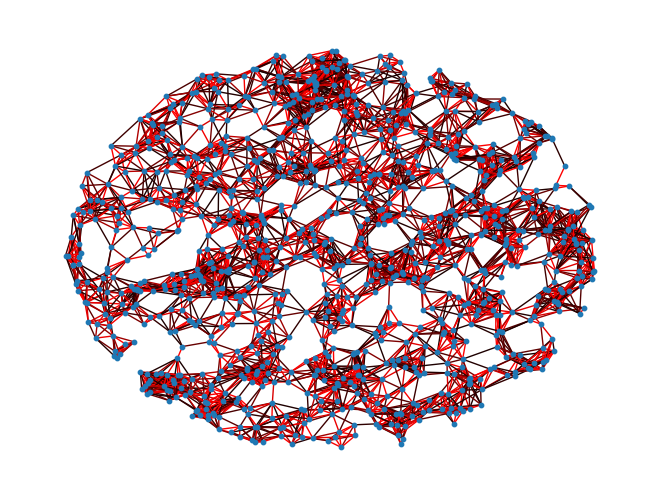

In [10]:
colors = np.array([ (prediction[0], 0, 0) for prediction in predictions if (prediction[0] >= 0.1)]) # if (prediction[0] >= prediction[1]) ])
options = {
    #"node_color": "#A0CBE2",
    "edge_color": colors,
    "node_size": 10,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
}
nx.draw(pred_graph, pos, **options)

wandb.log({
    "predicted_graph": wandb.Image(plt)
})